<a href="https://colab.research.google.com/github/freejae98/freejae98.github.io/blob/master/2022_10_12_New_Steel_v1_4_%EA%B8%B0%EA%B0%84%EB%B3%84_4%EA%B0%9C%EB%AA%A8%EB%8D%B8_%EC%A0%80%EC%9E%A5_%EB%AA%A8%EB%8D%B8_%EC%97%85%EB%8D%B0%EC%9D%B4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [2]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


In [3]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

from pickle import dump

In [4]:


# Data Loading
df = pd.read_excel('/content/(STEP_1) 원본.xlsx')   #dataset_6 사용
df.set_index('Date', inplace=True)

X_colname = ['MA5']
raw_all = df[X_colname]

# raw_all = df.loc[df['MA5'] != np.nan, :]

#20%는 테스트용 구분함
# PCT = 0.2
# c_num = int(len(raw_all.index) * (1- PCT))

# criteria = raw_all.index[int(c_num)]


# raw_all = df.loc[df.index >= '2019-12-30', X_colname]

# Parameters - 시작점을 달리할 경우 정확도에 어떤 영향을 얻을 수 있는지?

start_point = '2017-1-1'     #기존 시작점 : '2019-12-30'
# start_list = ['2016-1-1', '2018-1-1', '2020-1-1', '2021-1-1']     #기존 시작점 : '2019-12-30'
criteria = '2022-08-01'     #기존 시작점 : '2021-09-01'

scaler = preprocessing.MinMaxScaler()
sequence = 15   # → optimization 진행
batch_size = 16
epoch = 300
verbose = 1  # 원래는 1
dropout_ratio = 0

#며칠이나 이후 것을 예상할 것인지 (20 = 4주 후)
predict_day = 5    #5*1 # 1주 후

predict_day_list = [5, 10, 15, 20]    #각 1,2,3,4주 후



# Feature Engineering
## Train & Test Split
# train = raw_all.loc[raw_all.index < criteria,:]




  0%|          | 0/4 [00:00<?, ?it/s]

Train_size: (1449, 1) Test_size: (56, 1)
Train_start: 2017-01-02 00:00:00
Test_start: 2022-08-01 00:00:00
X_train: (1429, 15, 1) Y_train: (1429, 1)
X_test: (36, 15, 1) Y_test: (36, 1)
Epoch 1/300
90/90 [==============================] - 24s 167ms/step - loss: 0.0129 - val_loss: nan
Epoch 2/300
90/90 [==============================] - 8s 89ms/step - loss: 0.0020 - val_loss: nan
Epoch 3/300
90/90 [==============================] - 7s 76ms/step - loss: 0.0017 - val_loss: nan
Epoch 4/300
90/90 [==============================] - 7s 76ms/step - loss: 0.0017 - val_loss: nan
Epoch 5/300
90/90 [==============================] - 10s 111ms/step - loss: 0.0016 - val_loss: nan
Epoch 6/300
90/90 [==============================] - 13s 142ms/step - loss: 0.0013 - val_loss: nan
Epoch 7/300
90/90 [==============================] - 7s 78ms/step - loss: 0.0012 - val_loss: nan
Epoch 8/300
90/90 [==============================] - 7s 76ms/step - loss: 0.0011 - val_loss: nan
Epoch 9/300
90/90 [===============

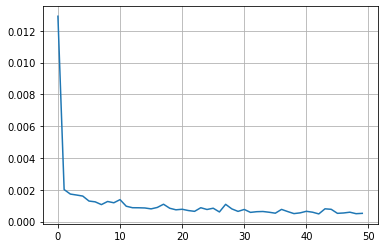

2/2 [==============================] - 0s 17ms/step - loss: 2.2204e-16


,MAE,MSE,MAPE
Train,9.74,223.46,1.51
Test,NaN,NaN,NaN


 25%|██▌       | 1/4 [06:22<19:08, 382.75s/it]

Train_size: (1449, 1) Test_size: (56, 1)
Train_start: 2017-01-02 00:00:00
Test_start: 2022-08-01 00:00:00
X_train: (1424, 15, 1) Y_train: (1424, 1)
X_test: (31, 15, 1) Y_test: (31, 1)
Epoch 1/300
89/89 [==============================] - 10s 75ms/step - loss: 0.0197 - val_loss: nan
Epoch 2/300
89/89 [==============================] - 6s 68ms/step - loss: 0.0035 - val_loss: nan
Epoch 3/300
89/89 [==============================] - 6s 69ms/step - loss: 0.0034 - val_loss: nan
Epoch 4/300
89/89 [==============================] - 6s 68ms/step - loss: 0.0033 - val_loss: nan
Epoch 5/300
89/89 [==============================] - 7s 83ms/step - loss: 0.0032 - val_loss: nan
Epoch 6/300
89/89 [==============================] - 6s 68ms/step - loss: 0.0026 - val_loss: nan
Epoch 7/300
89/89 [==============================] - 6s 69ms/step - loss: 0.0027 - val_loss: nan
Epoch 8/300
89/89 [==============================] - 6s 69ms/step - loss: 0.0027 - val_loss: nan
Epoch 9/300
89/89 [====================

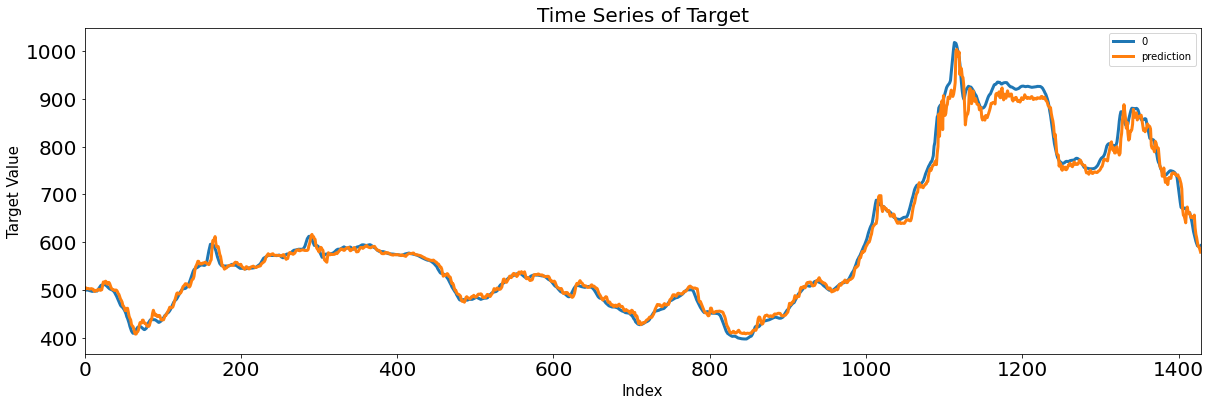

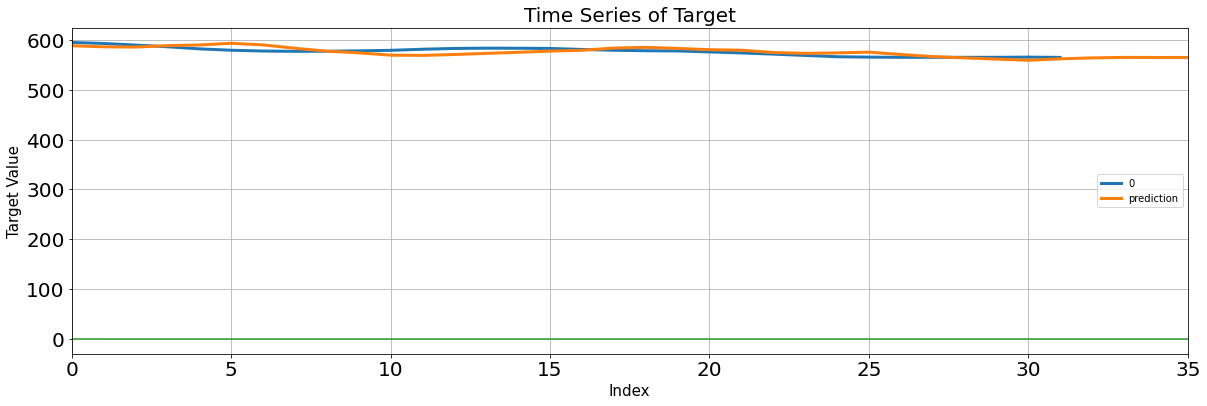

1/1 [==============================] - 0s 39ms/step - loss: 1.4325e-16


,MAE,MSE,MAPE
Train,16.39,575.82,2.65
Test,NaN,NaN,NaN


 50%|█████     | 2/4 [11:51<11:41, 350.77s/it]

Train_size: (1449, 1) Test_size: (56, 1)
Train_start: 2017-01-02 00:00:00
Test_start: 2022-08-01 00:00:00
X_train: (1419, 15, 1) Y_train: (1419, 1)
X_test: (26, 15, 1) Y_test: (26, 1)
Epoch 1/300
89/89 [==============================] - 13s 87ms/step - loss: 0.0169 - val_loss: nan
Epoch 2/300
89/89 [==============================] - 7s 78ms/step - loss: 0.0053 - val_loss: nan
Epoch 3/300
89/89 [==============================] - 7s 80ms/step - loss: 0.0053 - val_loss: nan
Epoch 4/300
89/89 [==============================] - 8s 92ms/step - loss: 0.0043 - val_loss: nan
Epoch 5/300
89/89 [==============================] - 7s 79ms/step - loss: 0.0042 - val_loss: nan
Epoch 6/300
89/89 [==============================] - 7s 78ms/step - loss: 0.0040 - val_loss: nan
Epoch 7/300
89/89 [==============================] - 7s 81ms/step - loss: 0.0038 - val_loss: nan
Epoch 8/300
89/89 [==============================] - 7s 79ms/step - loss: 0.0038 - val_loss: nan
Epoch 9/300
89/89 [====================

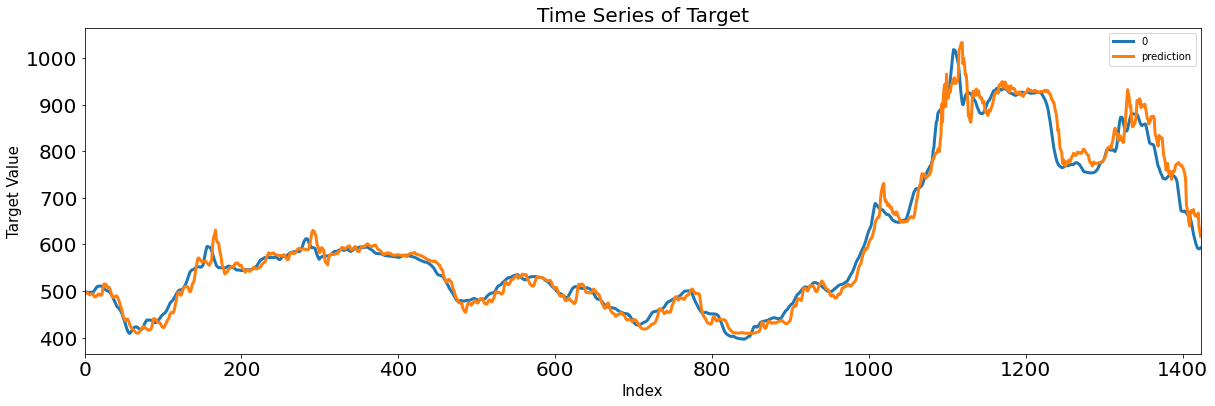

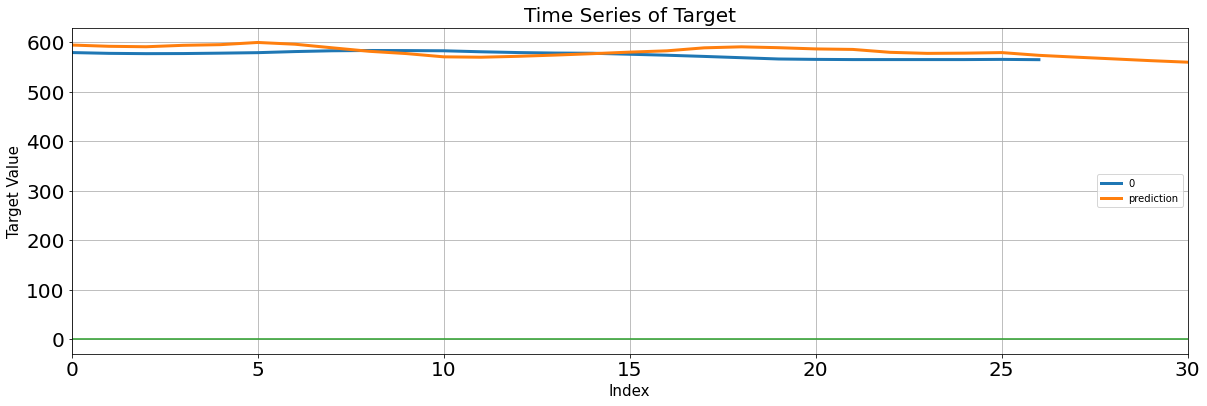

1/1 [==============================] - 0s 41ms/step - loss: 1.0248e-16


,MAE,MSE,MAPE
Train,20.45,870.07,3.31
Test,NaN,NaN,NaN


 75%|███████▌  | 3/4 [17:48<05:53, 353.87s/it]

Train_size: (1449, 1) Test_size: (56, 1)
Train_start: 2017-01-02 00:00:00
Test_start: 2022-08-01 00:00:00
X_train: (1414, 15, 1) Y_train: (1414, 1)
X_test: (21, 15, 1) Y_test: (21, 1)
Epoch 1/300
89/89 [==============================] - 14s 88ms/step - loss: 0.0195 - val_loss: nan
Epoch 2/300
89/89 [==============================] - 7s 80ms/step - loss: 0.0068 - val_loss: nan
Epoch 3/300
89/89 [==============================] - 7s 80ms/step - loss: 0.0065 - val_loss: nan
Epoch 4/300
89/89 [==============================] - 7s 79ms/step - loss: 0.0061 - val_loss: nan
Epoch 5/300
89/89 [==============================] - 7s 78ms/step - loss: 0.0060 - val_loss: nan
Epoch 6/300
89/89 [==============================] - 7s 78ms/step - loss: 0.0055 - val_loss: nan
Epoch 7/300
89/89 [==============================] - 7s 79ms/step - loss: 0.0057 - val_loss: nan
Epoch 8/300
89/89 [==============================] - 7s 78ms/step - loss: 0.0055 - val_loss: nan
Epoch 9/300
89/89 [====================

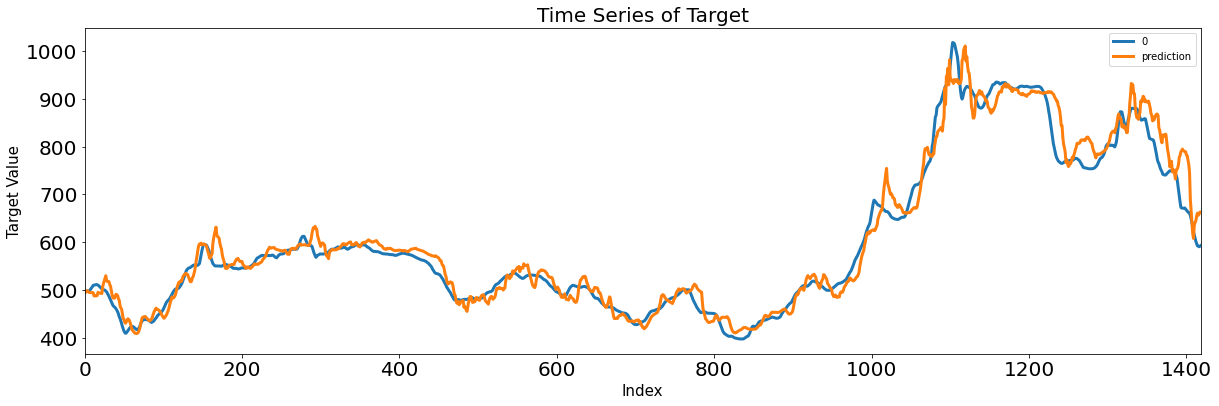

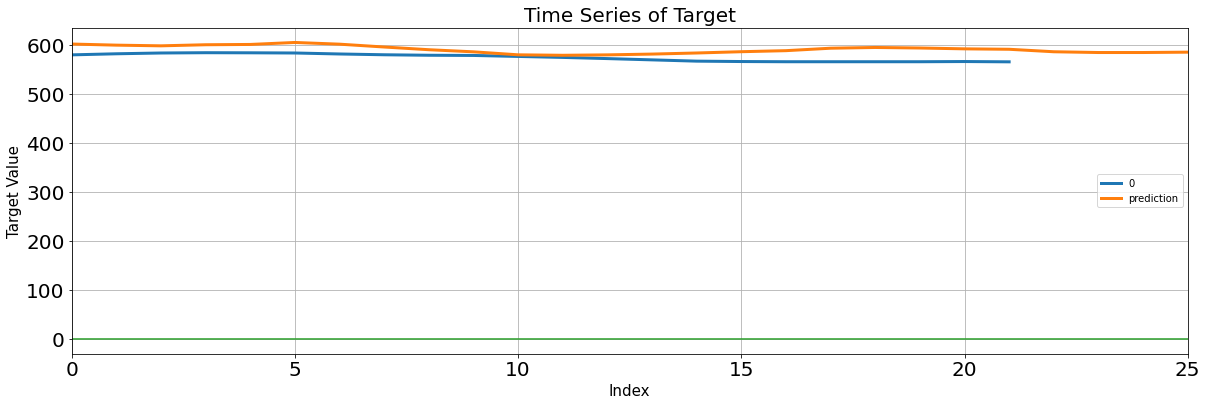

1/1 [==============================] - 0s 35ms/step - loss: 2.1147e-16


,MAE,MSE,MAPE
Train,24.96,"1,207.99",4.13
Test,NaN,NaN,NaN


100%|██████████| 4/4 [24:19<00:00, 364.95s/it]


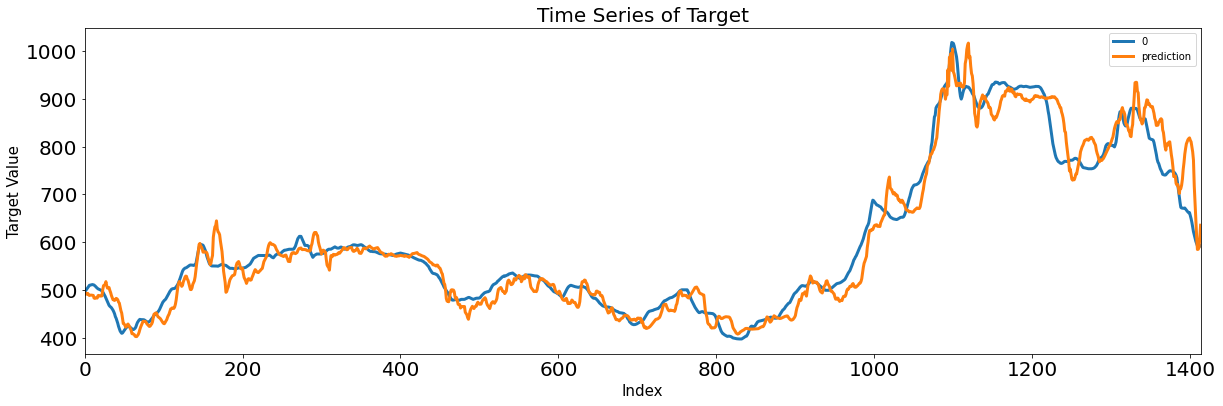

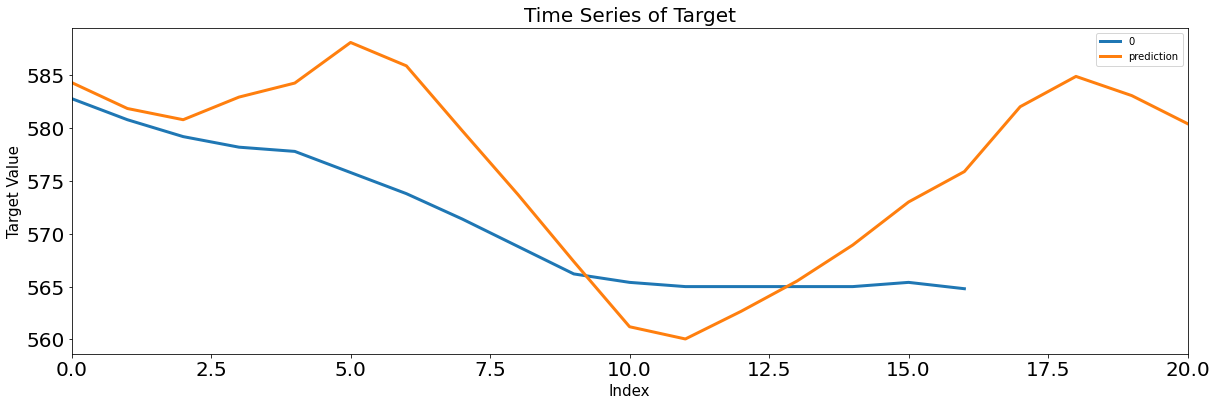

In [5]:
#################################################################################
#
# ----- Feature 1, GRU 버전 -------
#
#################################################################################

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 50, mode = 'min')


####################### iterations #######################
Score = dict()

temp = 0

# batchsize_list = [i for i in range(5, 11, 5)]
for i in tqdm(predict_day_list):
    # sequence = i
    # start_point = i

    predict_day = i   #예측일 변경

    temp = temp + 1


    train = raw_all.loc[(raw_all.index >= start_point) & (raw_all.index < criteria)]

    test = raw_all.loc[raw_all.index >= criteria,:]
    print('Train_size:', train.shape, 'Test_size:', test.shape)

    print('Train_start:', train.index[0])
    print('Test_start:', test.index[0])

    # Scaling
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)



    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(0, len(train_scaled) - sequence - predict_day):
        X_train.append(train_scaled[index: index + sequence])
        Y_train.append(train_scaled[index + sequence + predict_day])
    X_test, Y_test = [], []
    for index in range(0, len(test_scaled) - sequence - predict_day):
        X_test.append(test_scaled[index: index + sequence])
        Y_test.append(test_scaled[index + sequence + predict_day])

    ## Retype and Reshape
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose, validation_data=(X_test, Y_test), callbacks = [early_stopping])

    plt.plot(pd.DataFrame(model_fit.history))
    plt.grid(True)
    plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler != []:
        Y_train = scaler.inverse_transform(Y_train)
        Y_train_pred = scaler.inverse_transform(Y_train_pred)
        Y_test = scaler.inverse_transform(Y_test)
        Y_test_pred = scaler.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
    display(Score_GRU)
# if simul_test == 1:
    Score[str(predict_day)] = Score_GRU



    #모델, scaler 저장하기
    model.save("steel_" + str(temp) + "d.h5")

    dump(scaler, open("scaler_" + str(temp) + "d.pkl", 'wb'))



# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

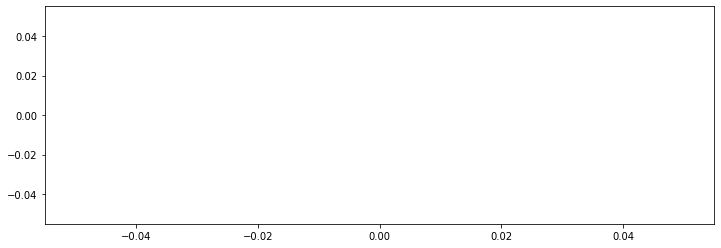

In [6]:
# if simul_test == 1:
# Performance plot by sequence length - 시퀀스/배치 변경에 따른 MSE 기록 -> 최적화 찾기 
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = predict_day_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()